## Problema 2:
Determine la deformación y los esfuerzos principales en función de la posición para una chapa con
un agujero en el centro sujeta a tracción por sus extremos, como se muestra en la figura. Las
dimensiones de la chapa son de 20 x 10 pulgadas y su espesor de una pulgada. El radio del agujero
central es también de 1 pulgada. Tome E = 30 x 106 psi y n = 0.30.
Analice el problema con número creciente de elementos y estudie su convergencia.
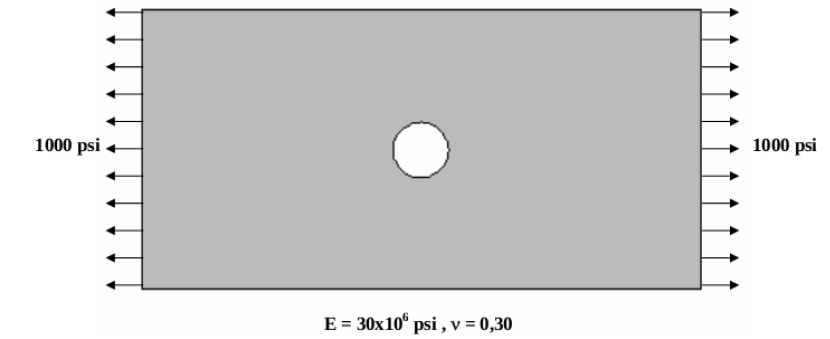

In [364]:
import numpy as np
import gmsh

In [365]:
#Cargo la geometria con gmsh

#Datos
E = 30e6
v = 0.3
tension = 1000
espesor = 1
radio = 1
w = 20
h = 10
glxn = 2

#Cargo la geometria con gmsh
gmsh.initialize()
gmsh.model.add('chapa2')

#Agrego los puntos
lc = 1       #Factor de escala

p1 = gmsh.model.geo.addPoint(w/2, 0, 0, lc)
p2 = gmsh.model.geo.addPoint(w/2, h/2-radio, 0, lc/5)
p3 = gmsh.model.geo.addPoint(w/2, h/2, 0, lc)
p4 = gmsh.model.geo.addPoint(w/2+radio, h/2, 0, lc/5)
p5 = gmsh.model.geo.addPoint(w, h/2, 0, lc)
p6 = gmsh.model.geo.addPoint(w, 0, 0, lc)


#Armo las lineas
l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p4, p5)
l3 = gmsh.model.geo.addLine(p5, p6)
l4 = gmsh.model.geo.addLine(p6, p1)
arc1 = gmsh.model.geo.addCircleArc(p2, p3, p4)   #Arco entre p2 y p4 con centro en p4

C1 = gmsh.model.geo.addCurveLoop([l1, arc1, l2, l3, l4])    #Genera el contorno, figura cerrada. lineas en orden

S1 = gmsh.model.geo.addPlaneSurface([C1]) #Genero la superficie delimitada por el contorno
gmsh.model.geo.synchronize()   #Sincronizamos lo cargado

#gmsh.fltk.run()

#Grupos fisicos:
EmpotradoX = gmsh.model.addPhysicalGroup(1, [l1])  #dimension 1, linea 4 --> grupo fisico
gmsh.model.setPhysicalName(1, EmpotradoX, 'EmpotradoX')   #Se le pone un nombre o categoria

EmpotradoY = gmsh.model.addPhysicalGroup(1, [l2])  #dimension 1, linea 4 --> grupo fisico
gmsh.model.setPhysicalName(1, EmpotradoY, 'EmpotradoY')   #Se le pone un nombre o categoria

Traccionado = gmsh.model.addPhysicalGroup(1, [l3])
gmsh.model.setPhysicalName(1, Traccionado, 'Traccionado')

Superficie = gmsh.model.addPhysicalGroup(2, [S1])
gmsh.model.setPhysicalName(2, Superficie, 'Superficie')

NodosElim = gmsh.model.addPhysicalGroup(0, [p3])
gmsh.model.setPhysicalName(2, NodosElim, 'NodosElim')

TracEsq = gmsh.model.addPhysicalGroup(0, [p5, p6])
gmsh.model.setPhysicalName(0, TracEsq, 'TracEsq')

gmsh.model.mesh.generate(2)

gmsh.model.geo.synchronize()   #Sincronizamos lo cargado
gmsh.fltk.run()


#Armo MC y MN:
NodeInfo = gmsh.model.mesh.get_nodes()
NumeroNodos = NodeInfo[0].shape[0]

MN = NodeInfo[1].reshape(NumeroNodos , 3)

ElementInfo = gmsh.model.mesh.get_elements()    #Recupera los elementos 
ETYPES = ElementInfo[0]

ETAGS, ELEMENTS = gmsh.model.mesh.get_elements_by_type(2)  #Este metodo toma solo los triangulos (2)
MC = ELEMENTS.reshape([ETAGS.shape[0],3]) - 1

NumeroElem = len(MC)

#Condiciones de contorno
NodosTraccionados = gmsh.model.mesh.get_nodes_for_physical_group(1,Traccionado)[0].astype(int)-1

entityTraccionada = gmsh.model.getEntitiesForPhysicalGroup(1, Traccionado)
Tgroup, Ttraccionada, Ltraccionada = gmsh.model.mesh.getElements(1, entityTraccionada[0])  #Ltraccionada: puntos que definen la linea
Ltraccionada = Ltraccionada[0].reshape(Ttraccionada[0].shape[0],2)   #Columna de segmentos

Longitudes = np.abs(MN[Ltraccionada[:,0]-1,1] - MN[Ltraccionada[:,1]-1,1] )


#Calculo las fuerzas distribuidas
fuerza = np.zeros((2*NumeroNodos,1))

for l, linea in enumerate(Ltraccionada):
    Flocal = np.array([[1],[1]])*tension*espesor*Longitudes[l]
    n1 = linea[0]
    n2 = linea[1]
    #print(Flocal)
    fuerza[ np.array([2*(n1-1), 2*(n2-1)], dtype=int)] += Flocal

#Nodos empotrados y eliminados
NodosEmpotradosX = gmsh.model.mesh.get_nodes_for_physical_group(1, EmpotradoX)[0].astype(int)-1
NodosEmpotradosY = gmsh.model.mesh.get_nodes_for_physical_group(1, EmpotradoY)[0].astype(int)-1
NodosElim = gmsh.model.mesh.get_nodes_for_physical_group(0, NodosElim)[0].astype(int)-1
MNE = NodosEmpotrados[1].reshape((NodosEmpotrados[0].shape[0], 3))


#Defino vectores r y s:
s = []
r = np.arange(2*NumeroNodos)    #Cargo todos los nodos (*2) para los indices de la matriz_global
for n, nodo in enumerate(NodosEmpotradosX):
    s.append(2*nodo)                     #Solo elimino el grado de libertad en x
    
for n, nodo in enumerate(NodosEmpotradosY):
    s.append(2*nodo+1) 
    
for n, nodo in enumerate(NodosElim):       #Saco los nodos extras (radio del arco)
    s.append(2*nodo) 
    s.append(2*nodo +1)
    
s = np.array(s).astype(int)  #Nodos con desplazamiento cero    
r = np.delete( r, s )       #Saco de r todo lo que puse en s   (con r armo la matriz reducida luego, desplazamientos desc.)




In [366]:
ELEMENTS

array([ 66, 114, 155, ..., 183,  53, 187], dtype=uint64)

In [367]:
#Matrices del problema
Matriz_D = (E/(1-v**2))*np.array([[1, v, 0], [v, 1, 0], [0, 0, 0.5*(1-v)]])
Matriz_K = np.zeros([glxn*NumeroNodos, glxn*NumeroNodos])   #Matriz global
Matriz_coor = np.ones((3,3)) 
Matriz_loc_B = []
areas = []
desp = np.zeros([2*NumeroNodos, 1])

for e in range(0, NumeroElem):
    i, m, j = MC[e]    #Nodos de cada elemento

    x = np.array([MN[i,0],MN[m,0],MN[j,0]])  #coordenada x de cada elemento
    y = np.array([MN[i,1],MN[m,1],MN[j,1]])  #coordenada y de cada elemento
   
    #Ai,j,m = 0 luego de derivar las Ni
    Bi = y[2] - y[1]; Bj = y[1] - y[0]; Bm = y[0] - y[2]
    Gi = x[1] - x[2]; Gj = x[0] - x[1]; Gm = x[2] - x[0]
    #print(Bi, Bj, Bm)
    #print(Gi, Gj, Gm)
    
    #armo la matriz de coordenadas
    Matriz_coor[:,1] = x
    Matriz_coor[:,2] = y
    
    area = np.linalg.det(Matriz_coor)/2   #Obtengo A
    areas.append(area)
    
    #Armo matriz para las deformaciones (deriv de u), derivadas de funcion interp (N_i,j,m):
    Matriz_B = (1/(2*abs(area)))*np.array([[Bi, 0, Bm, 0, Bj, 0], [0, Gi, 0, Gm, 0, Gj], [Gi, Bi, Gm, Bm, Gj, Bj]])   
    Matriz_loc_B.append(Matriz_B)
    
    #Armo la matriz global
    Matriz_local = espesor * abs(area) * (np.dot(np.transpose(Matriz_B), np.dot(Matriz_D, Matriz_B)))
    ind_glob = np.array([2*i, 2*i+1, 2*m, 2*m+1, 2*j, 2*j+1])  #Posiciones en la matriz global (elementos 0, 1, 2 y 3)
    ind_glob = ind_glob.astype(int)
    Matriz_K[np.ix_(ind_glob, ind_glob)] += Matriz_local


In [368]:
#CALCULO LOS DESPLAZAMIENTOS:

#Matriz reducida:
s = s.reshape(-1,1)
Matriz_red = Matriz_K[np.ix_(r, r)]
fuerza_r = np.array(fuerza[np.array([r])]).reshape(-1,1)  #Fuerzas conocidas c.c

desp_inc = np.linalg.solve(Matriz_red, fuerza_r - Matriz_K[np.ix_(r, s.reshape(-1,))].dot(u[s]))  
desp[r] += desp_inc

#Fuerzas restantes:
fuerza[s] = Matriz_K[s,:].dot(desp)

#Tensiones:
tensiones = []
for e in range(0, NumeroElem): 
    i, m, j = MC[e].astype(int)
    #print(e)
    desp_elem = np.array([[desp[2*i], desp[2*i+1], desp[2*m], desp[2*m+1], desp[2*j], desp[2*j+1]]])  
    tension = np.dot(Matriz_D, np.dot(Matriz_loc_B[e], desp_elem.reshape(-1,1)))
    tensiones.append(tension)

tensiones = np.array(tensiones)

desp_tot = np.insert(desp.reshape(-1,2), 2, np.zeros([1, NumeroNodos]), axis=1)   #Desplazamientos en x, y, z
 


In [369]:
#Visualizar los resultados en gmsh

desps = gmsh.view.add("Desplazamiento")
ViewTension = gmsh.view.add("Tension")

Desps = gmsh.view.addModelData(desps, 0, 'chapa2', 'NodeData', NodeInfo[0], desp_tot, numComponents = 3)
Tens = gmsh.view.addModelData(ViewTension, 0, 'chapa2', 'ElementData', ETAGS, tensiones[:,0].reshape(-1,1), numComponents = 1)

gmsh.fltk.run()
gmsh.finalize()


In [371]:
NodeInfo[0]

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18